# **2. Exploratory Data Analysis**

## **Part 0: Import Modules**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
import pickle
import os
import warnings # For handling error messages.
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.core.common.SettingWithCopyWarning)
warnings.filterwarnings('ignore', category=stats.ConstantInputWarning)
plt.style.use('ggplot')

In [2]:
filepath = '../FinalDFs/PostWrangling/'

## **Part 1: Batters**

### **(I) Loading and Cleaning the data**

In [3]:
batting_file = filepath + 'batting_merged.pkl'

# Load the .pkl file as a dataframe
batting_df = pd.read_pickle(batting_file)
batting_df.head()

Player       Country                  Role Season  \
11  AB de Villiers  South Africa  Wicketkeeper batsman   2008   
10  AB de Villiers  South Africa  Wicketkeeper batsman   2009   
9   AB de Villiers  South Africa  Wicketkeeper batsman   2010   
8   AB de Villiers  South Africa  Wicketkeeper batsman   2011   
7   AB de Villiers  South Africa  Wicketkeeper batsman   2012   

                           Team  SalaryUSD MatchCount  SeasonCount  \
11             Delhi Daredevils     300000          6            1   
10             Delhi Daredevils     300000         15            2   
9              Delhi Daredevils     300000          7            3   
8   Royal Challengers Bangalore    1100000         16            4   
7   Royal Challengers Bangalore    1100000         15            5   

    balls_faced  total_runs  batting_avg  strike_rate  50s  100s    4s    6s  
11        100.0        95.0    23.750000    95.000000  0.0   0.0   5.0   1.0  
10        359.0       465.0    51.666667   129.526462  3.0   1.0  39.0  12.0  
9         123.0       111.0    15.857143    90.243902  0.0   0.0   7.0   0.0  
8         248.0       312.0    39.000000   125.806452  2.0   0.0  21.0  14.0  
7         203.0       319.0    39.875000   157.142857  3.0   0.0  26.0  15.0

In [4]:
# Turn the match count and phase into integers
batting_df = batting_df.dropna()

col_list = ['MatchCount', 'balls_faced', 'total_runs', '50s', '100s', '4s', '6s']
for col in col_list:
    batting_df[col] = batting_df[col].astype('int')

In [5]:
# Map the categories in 'Role' column to corresponding numeric values
role_list = list(batting_df.Role.unique())
role_map = {role: 1 if role=='Allrounder' else 0 for role in role_list}
batting_df.Role = batting_df.Role.map(role_map)

In [6]:
# Let us now check for NaN values
bat_columns_with_nan = batting_df.columns[batting_df.isna().any()].tolist()
print(bat_columns_with_nan)

[]


In [7]:
batting_df = batting_df.reset_index(drop=True)

In [8]:
# Let us now keep track of when a player changed teams
batting_df['changed_teams'] = 0
changed_teams_years = (batting_df['Player'] == batting_df['Player'].shift(1)) & (batting_df['Team'] != batting_df['Team'].shift(1))
batting_df.loc[changed_teams_years, 'changed_teams'] = 1

In [9]:
# Let us also keep track of the next-year salary
batting_df['NY_SalaryUSD'] = np.nan
player_change = (batting_df['Player'] != batting_df['Player'].shift(-1))
batting_df.loc[~player_change, 'NY_SalaryUSD'] = batting_df['SalaryUSD'].shift(-1)
batting_df['NY_SalaryUSD'] = batting_df['NY_SalaryUSD'].astype('float')

In [10]:
# inspect the final df
batting_df.dropna(subset=['NY_SalaryUSD'], inplace=True)
batting_df.head()

Player       Country  Role Season                         Team  \
0  AB de Villiers  South Africa     0   2008             Delhi Daredevils   
1  AB de Villiers  South Africa     0   2009             Delhi Daredevils   
2  AB de Villiers  South Africa     0   2010             Delhi Daredevils   
3  AB de Villiers  South Africa     0   2011  Royal Challengers Bangalore   
4  AB de Villiers  South Africa     0   2012  Royal Challengers Bangalore   

   SalaryUSD  MatchCount  SeasonCount  balls_faced  total_runs  batting_avg  \
0     300000           6            1          100          95    23.750000   
1     300000          15            2          359         465    51.666667   
2     300000           7            3          123         111    15.857143   
3    1100000          16            4          248         312    39.000000   
4    1100000          15            5          203         319    39.875000   

   strike_rate  50s  100s  4s  6s  changed_teams  NY_SalaryUSD  
0    95.000000    0     0   5   1              0      300000.0  
1   129.526462    3     1  39  12              0      300000.0  
2    90.243902    0     0   7   0              0     1100000.0  
3   125.806452    2     0  21  14              1     1100000.0  
4   157.142857    3     0  26  15              0     1100000.0

In [11]:
# inspect the shape of the df
batting_df.shape

(713, 18)

In [12]:
# check for null values
null_counts = batting_df.isnull().sum()
num_rows_with_null = len(null_counts[null_counts != 0])
num_rows_with_null

0

In [13]:
# inspect the data types present
batting_df.dtypes

Player            object
Country           object
Role               int64
Season            object
Team              object
SalaryUSD          int64
MatchCount         int64
SeasonCount        int64
balls_faced        int64
total_runs         int64
batting_avg      float64
strike_rate      float64
50s                int64
100s               int64
4s                 int64
6s                 int64
changed_teams      int64
NY_SalaryUSD     float64
dtype: object

In [14]:
# inspect the basic summary stats
batting_df.describe()

Role     SalaryUSD  MatchCount  SeasonCount  balls_faced  \
count  713.000000  7.130000e+02  713.000000   713.000000   713.000000   
mean     0.380084  6.999802e+05   10.820477     4.570827   174.179523   
std      0.485748  6.019141e+05    4.730225     2.866082   124.985398   
min      0.000000  1.500000e+04    1.000000     1.000000     1.000000   
25%      0.000000  2.500000e+05    7.000000     2.000000    66.000000   
50%      0.000000  5.410000e+05   12.000000     4.000000   159.000000   
75%      1.000000  9.166670e+05   14.000000     6.000000   270.000000   
max      1.000000  3.000000e+06   19.000000    12.000000   655.000000   

       total_runs  batting_avg  strike_rate         50s        100s  \
count  713.000000   713.000000   713.000000  713.000000  713.000000   
mean   223.138850    26.670058   122.291796    1.252454    0.064516   
std    169.341791    14.451301    29.960132    1.592891    0.287942   
min      0.000000     0.000000     0.000000    0.000000    0.000000   
25%     78.000000    17.000000   108.695652    0.000000    0.000000   
50%    195.000000    25.333333   123.316062    1.000000    0.000000   
75%    340.000000    34.230769   137.037037    2.000000    0.000000   
max    973.000000   109.000000   300.000000    9.000000    4.000000   

               4s          6s  changed_teams  NY_SalaryUSD  
count  713.000000  713.000000     713.000000  7.130000e+02  
mean    20.343619    8.626928       0.224404  7.323850e+05  
std     17.176987    8.558848       0.417482  6.197689e+05  
min      0.000000    0.000000       0.000000  1.500000e+04  
25%      6.000000    2.000000       0.000000  2.656300e+05  
50%     17.000000    6.000000       0.000000  5.410000e+05  
75%     31.000000   13.000000       0.000000  9.750000e+05  
max     88.000000   59.000000       1.000000  3.000000e+06

### **(II) Initial Visualizations and Correlations**

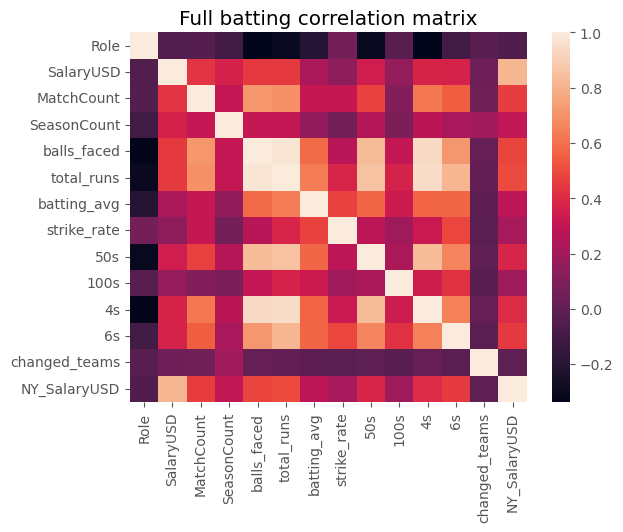

In [15]:
# find the correlations of the variables amongst each other
batting_corr = batting_df.corr()
sns.heatmap(batting_corr)
plt.title('Full batting correlation matrix')
plt.show()

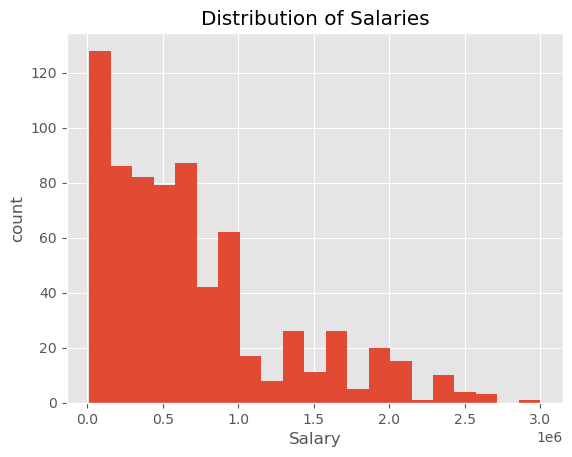

In [16]:
batting_df.SalaryUSD.hist(bins='auto')
plt.xlabel('Salary')
plt.ylabel('count')
plt.title('Distribution of Salaries')
plt.show()

#### (a) General Player Statistics

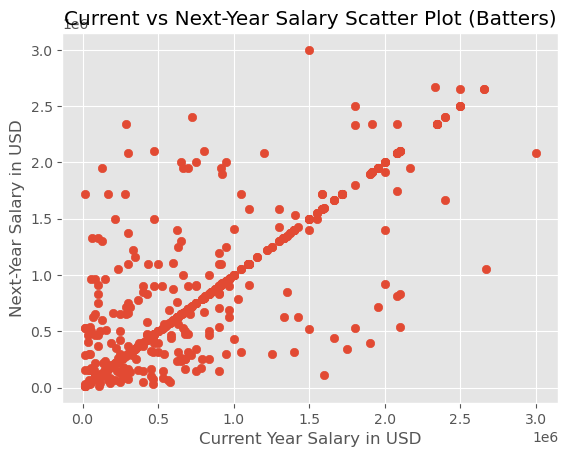

In [32]:
plt.scatter(batting_df['SalaryUSD'], batting_df['NY_SalaryUSD'])
plt.xlabel('Current Year Salary in USD')
plt.ylabel('Next-Year Salary in USD')
plt.title('Current vs Next-Year Salary Scatter Plot (Batters)')
plt.show()

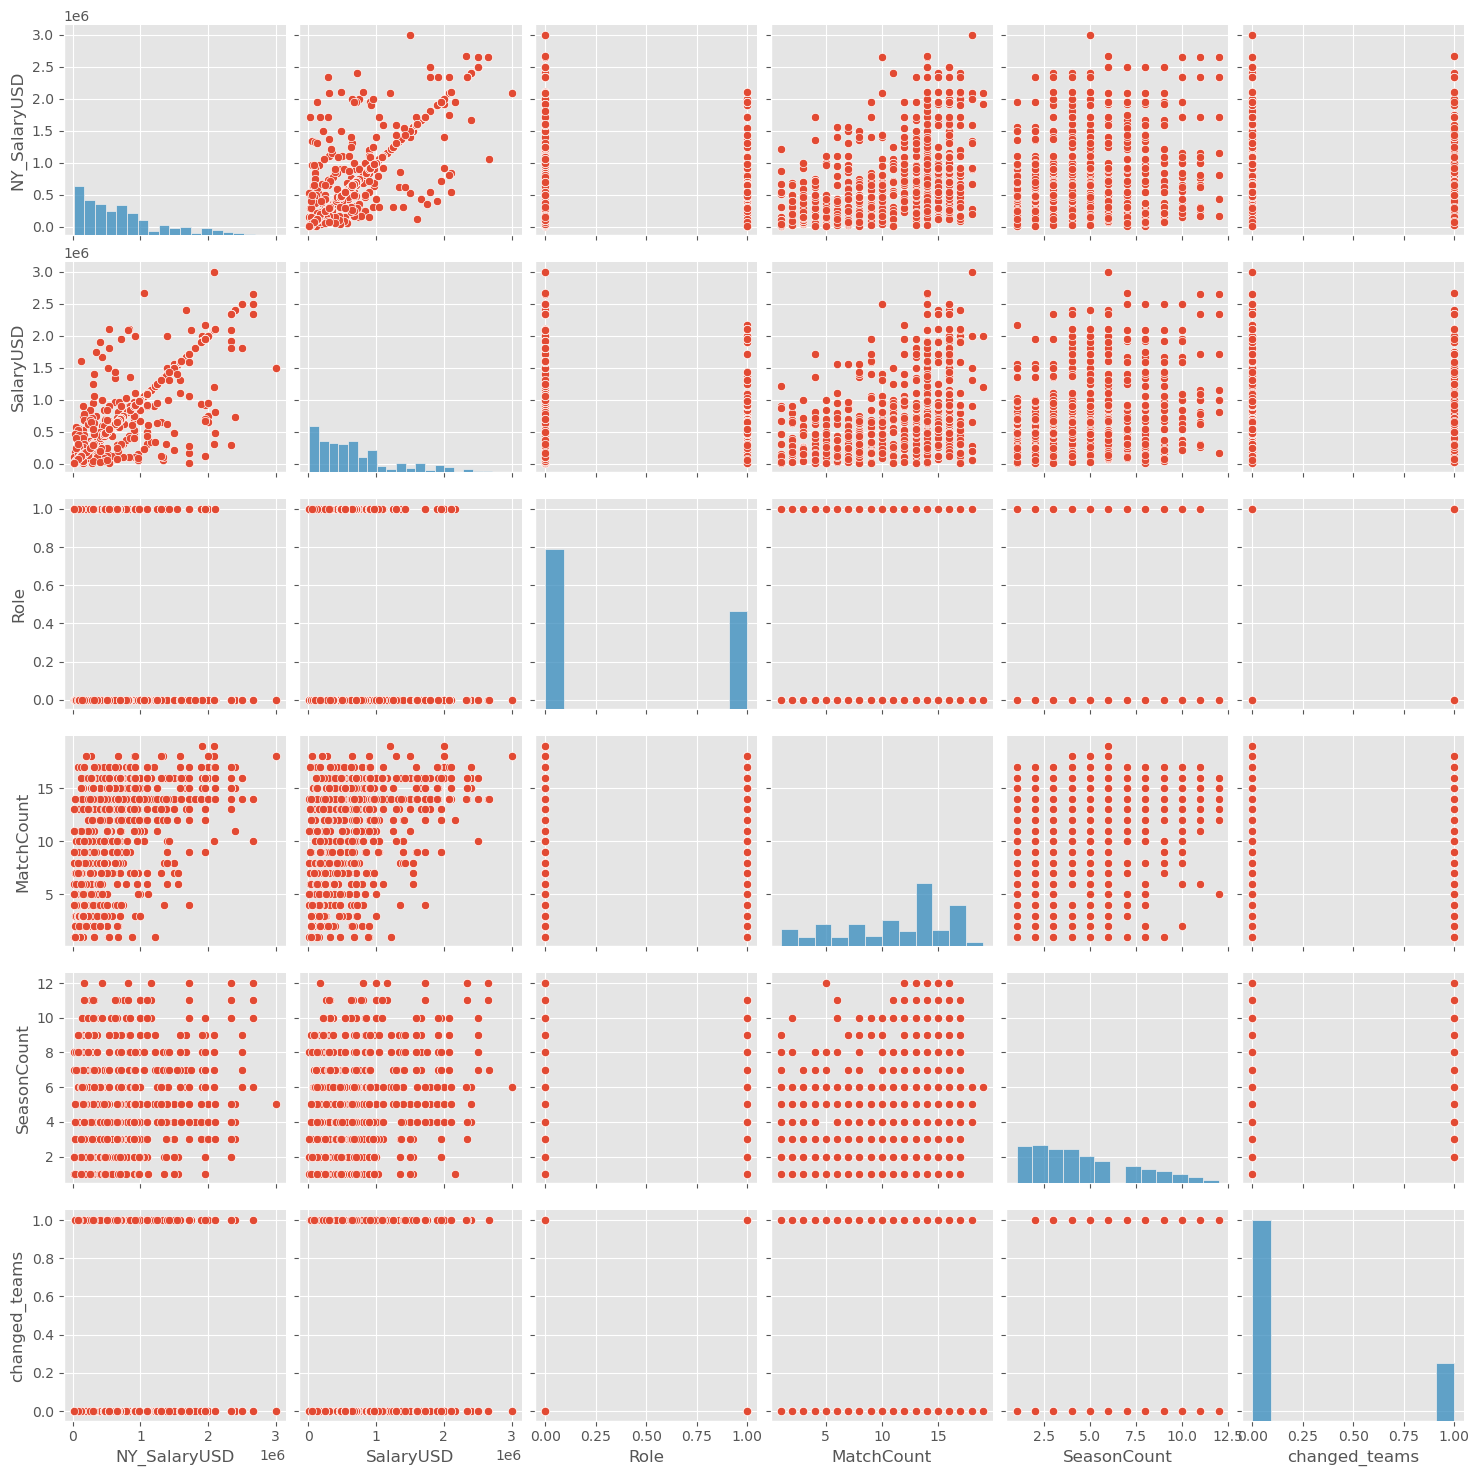

In [54]:
# Let us pairplot the salary with the other general player stats
gen_columns = ['NY_SalaryUSD', 'SalaryUSD', 'Country', 'Role', 'Team', 'MatchCount', 'SeasonCount', 'changed_teams']
gen_batting_df = batting_df[gen_columns].copy()

sns.pairplot(gen_batting_df)
plt.show()

In [55]:
gen_batting_df.corr()

NY_SalaryUSD  SalaryUSD      Role  MatchCount  SeasonCount  \
NY_SalaryUSD       1.000000   0.816069 -0.058448    0.456904     0.295119   
SalaryUSD          0.816069   1.000000 -0.053690    0.435685     0.367225   
Role              -0.058448  -0.053690  1.000000   -0.042391    -0.102593   
MatchCount         0.456904   0.435685 -0.042391    1.000000     0.308002   
SeasonCount        0.295119   0.367225 -0.102593    0.308002     1.000000   
changed_teams     -0.009146   0.043642 -0.033337    0.047455     0.200329   

               changed_teams  
NY_SalaryUSD       -0.009146  
SalaryUSD           0.043642  
Role               -0.033337  
MatchCount          0.047455  
SeasonCount         0.200329  
changed_teams       1.000000

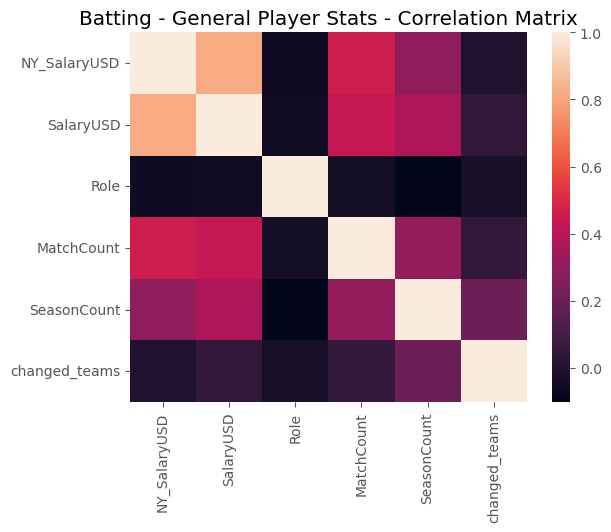

In [56]:
sns.heatmap(gen_batting_df.corr())
plt.title('Batting - General Player Stats - Correlation Matrix')
plt.show()

#### (b) Player performance statistics

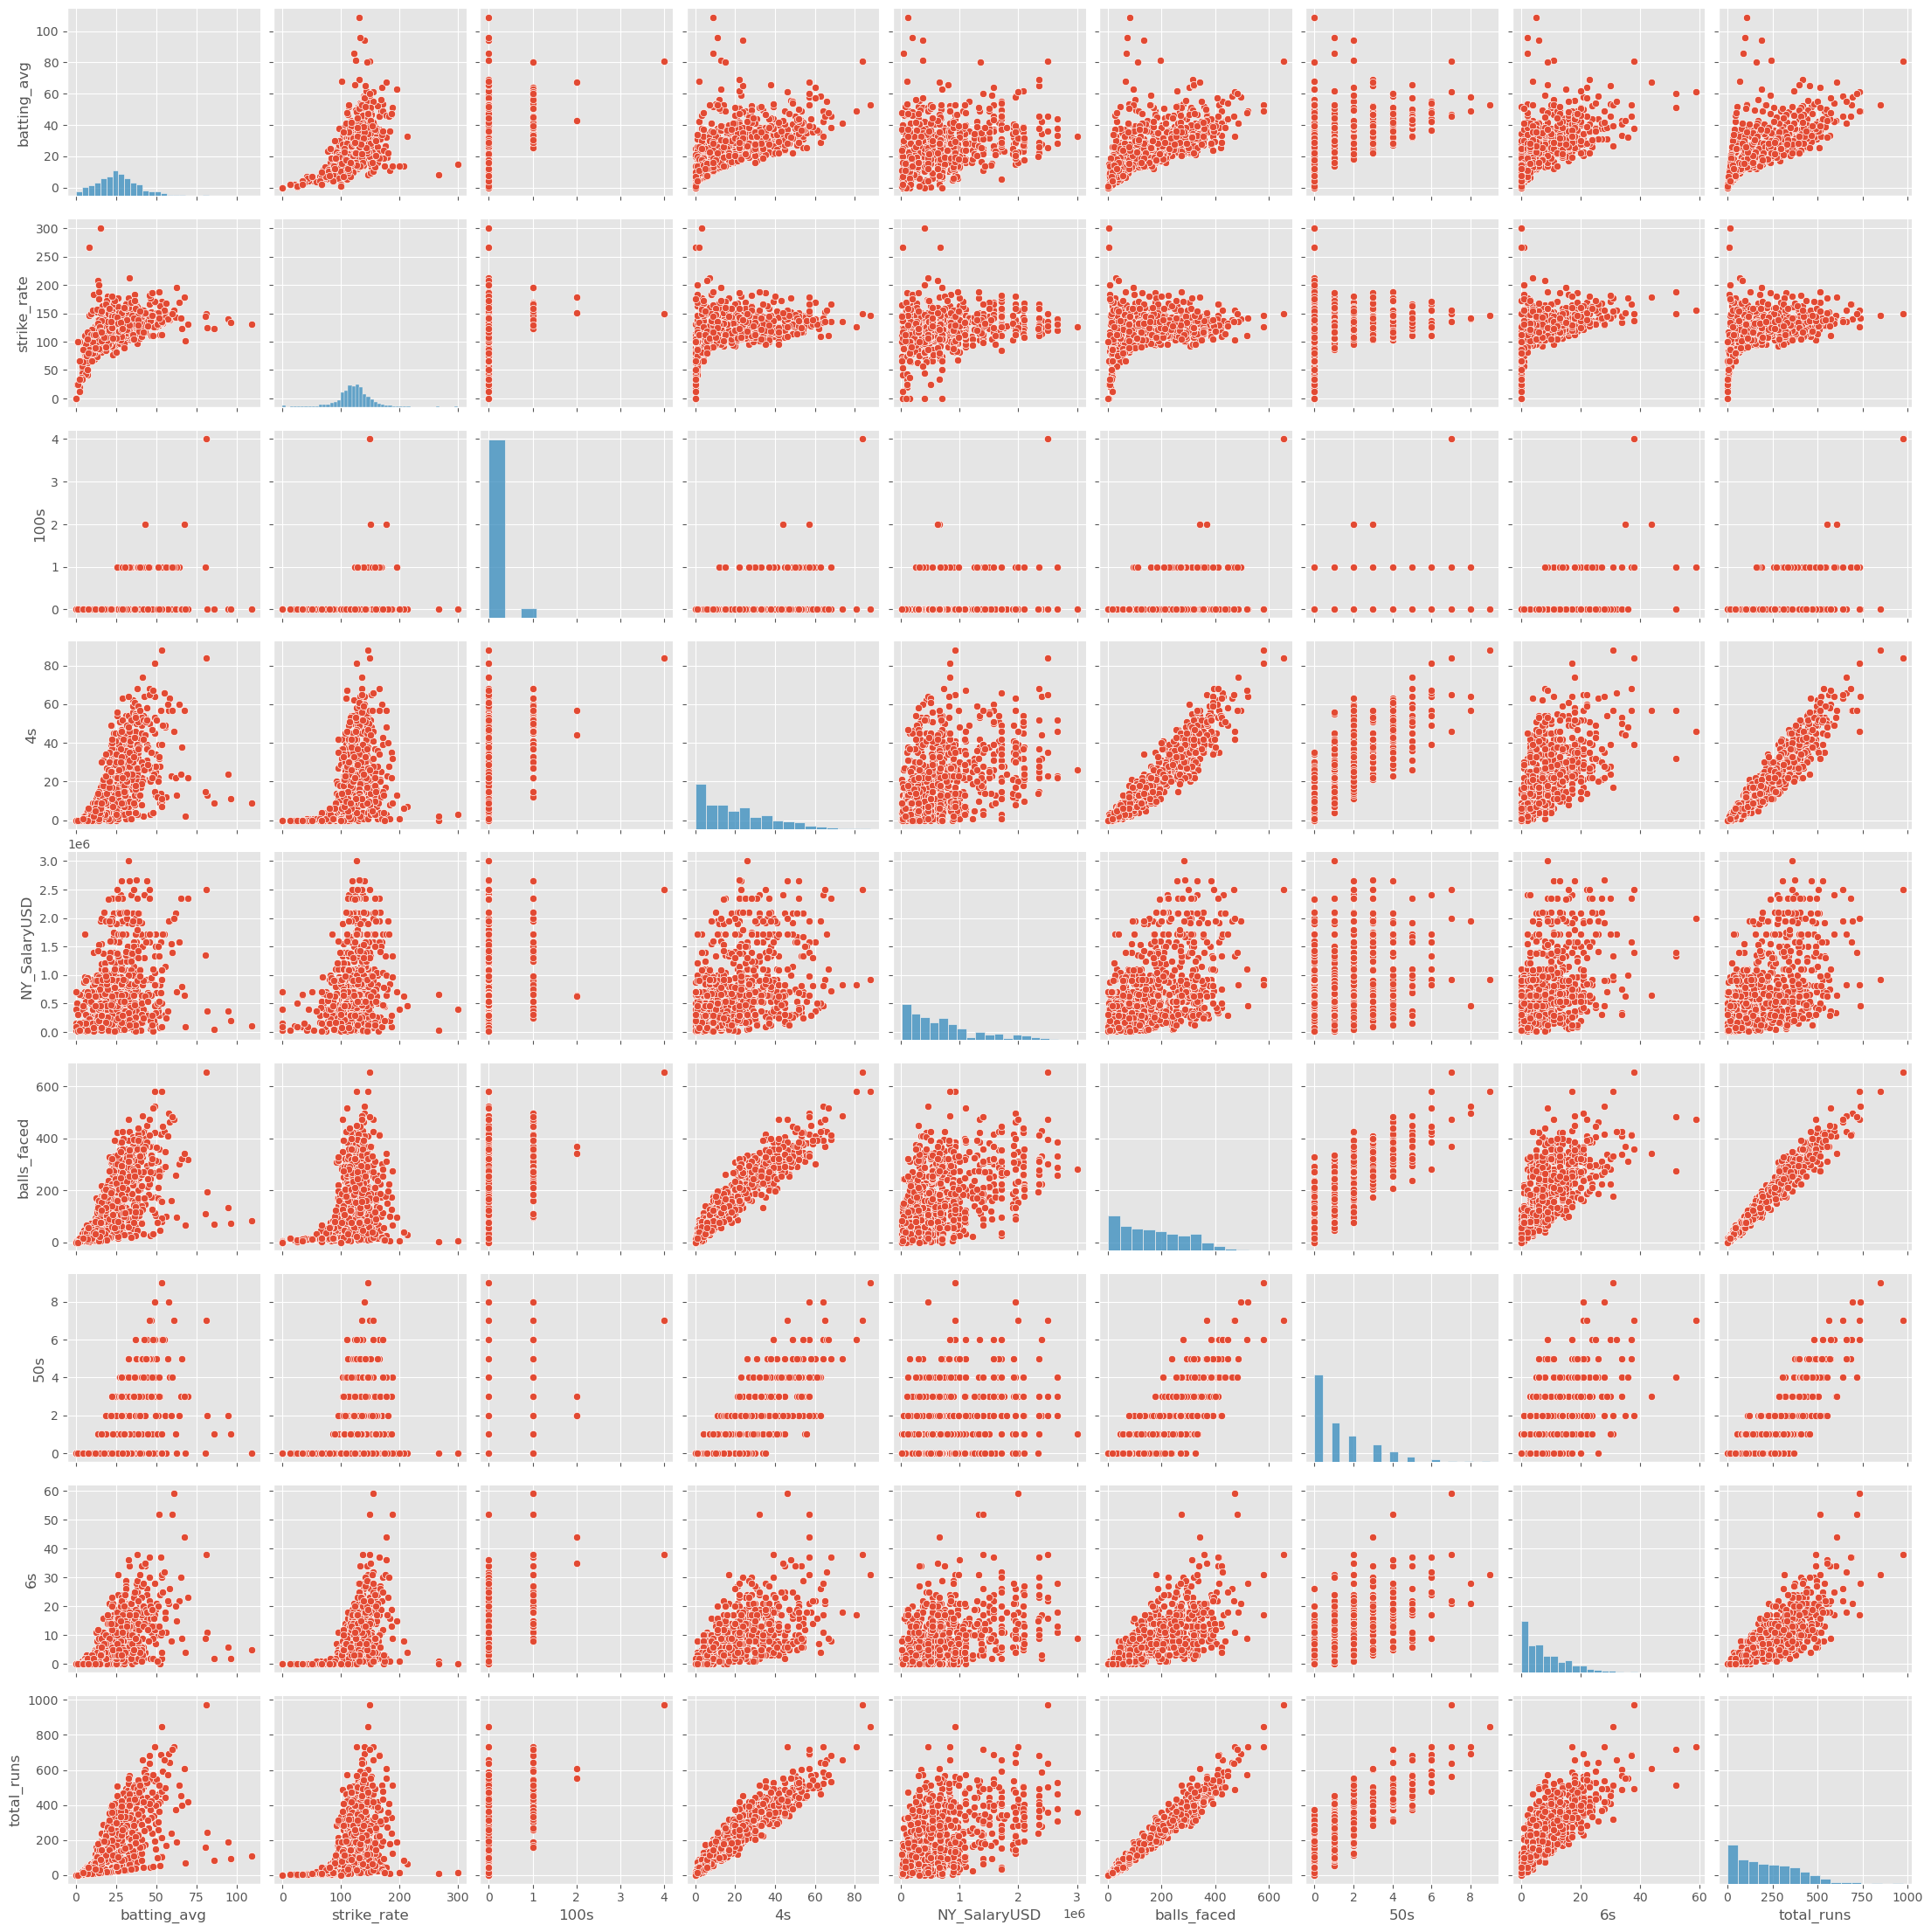

In [57]:
# Let's do the same thing for the statistics columns
stats_cols = list(set(batting_df.columns) - set(gen_columns[1:]))
stats_cols = [col for col in stats_cols if col not in ['Player', 'Role', 'Season', 'SalaryUSD']]
stats_batting_df = batting_df[stats_cols]

sns.pairplot(stats_batting_df)
plt.show()

In [58]:
stats_batting_df.corr()

batting_avg  strike_rate      100s        4s  NY_SalaryUSD  \
batting_avg      1.000000     0.475347  0.330311  0.566043      0.281377   
strike_rate      0.475347     1.000000  0.191985  0.325194      0.214237   
100s             0.330311     0.191985  1.000000  0.337692      0.191606   
4s               0.566043     0.325194  0.337692  1.000000      0.400245   
NY_SalaryUSD     0.281377     0.214237  0.191606  0.400245      1.000000   
balls_faced      0.583998     0.270947  0.303457  0.936685      0.480560   
50s              0.568615     0.283626  0.224724  0.832200      0.380550   
6s               0.567767     0.486030  0.421249  0.645498      0.447659   
total_runs       0.636329     0.382164  0.372567  0.943485      0.496221   

              balls_faced       50s        6s  total_runs  
batting_avg      0.583998  0.568615  0.567767    0.636329  
strike_rate      0.270947  0.283626  0.486030    0.382164  
100s             0.303457  0.224724  0.421249    0.372567  
4s               0.936685  0.832200  0.645498    0.943485  
NY_SalaryUSD     0.480560  0.380550  0.447659    0.496221  
balls_faced      1.000000  0.830406  0.713102    0.976704  
50s              0.830406  1.000000  0.660267    0.856074  
6s               0.713102  0.660267  1.000000    0.813234  
total_runs       0.976704  0.856074  0.813234    1.000000

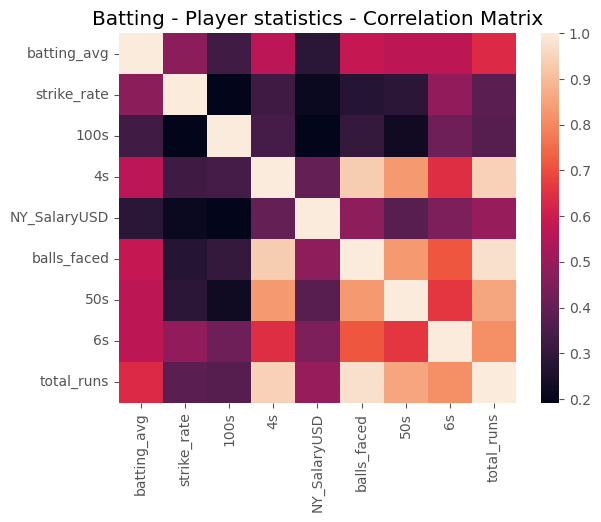

In [59]:
sns.heatmap(stats_batting_df.corr())
plt.title('Batting - Player statistics - Correlation Matrix')
plt.show()

### **(III) Statistical Significance**

#### (a) General Statistics

In [63]:
ny_salary = gen_batting_df.NY_SalaryUSD
gen_cols_corr = [col for col in gen_columns if col not in ['NY_SalaryUSD', 'Country', 'Team']]

for col in gen_cols_corr:
    correlation_coef, p_value = stats.pearsonr(ny_salary, gen_batting_df[col])
    if p_value < 0.05:
        print(f"Correlation coefficient {col}:", correlation_coef)
        print(f"P-value {col}:", p_value)

Correlation coefficient SalaryUSD: 0.8160691555566204
P-value SalaryUSD: 1.8624314776994566e-171
Correlation coefficient MatchCount: 0.4569037604495704
P-value MatchCount: 4.5932716614179863e-38
Correlation coefficient SeasonCount: 0.29511891321800576
P-value SeasonCount: 8.530137934210675e-16


#### (b) Player Performance Statistics

In [64]:
ny_salary = stats_batting_df.NY_SalaryUSD
stats_cols_corr = list(stats_batting_df.columns)[1:]

for col in stats_cols_corr:
    correlation_coef, p_value = stats.pearsonr(ny_salary, stats_batting_df[col])
    if p_value < 0.05:
        print(f"Correlation coefficient {col}:", correlation_coef)
        print(f"P-value {col}:", p_value)

Correlation coefficient strike_rate: 0.21423662917628888
P-value strike_rate: 7.571262704509749e-09
Correlation coefficient 100s: 0.19160630144211035
P-value 100s: 2.534365424812857e-07
Correlation coefficient 4s: 0.40024500160369436
P-value 4s: 8.234475888426899e-29
Correlation coefficient NY_SalaryUSD: 1.0
P-value NY_SalaryUSD: 0.0
Correlation coefficient balls_faced: 0.48056019527838045
P-value balls_faced: 1.7837750246833845e-42
Correlation coefficient 50s: 0.3805502757369348
P-value 50s: 5.478194370334931e-26
Correlation coefficient 6s: 0.4476592510189872
P-value 6s: 1.9679477814788038e-36
Correlation coefficient total_runs: 0.4962205751391645
P-value total_runs: 1.36693579971408e-45


### **(IV) PCA**

In [65]:
# Standardize the numerical columns
scaler_batting = StandardScaler()
scaled_stats_batting = scaler_batting.fit_transform(stats_batting_df)

In [66]:
# Perform PCA
pca_batting = PCA()
principal_components_batting = pca_batting.fit_transform(scaled_stats_batting)

In [67]:
# Explained variance ratio
explained_variance_ratio_batting = pca_batting.explained_variance_ratio_

# Print the explained variance ratio for each principal component
for i, ratio in enumerate(explained_variance_ratio_batting):
    print(f"Explained variance ratio for PC{i+1} (batting): {ratio:.4f}")

Explained variance ratio for PC1 (batting): 0.5979
Explained variance ratio for PC2 (batting): 0.1132
Explained variance ratio for PC3 (batting): 0.0922
Explained variance ratio for PC4 (batting): 0.0850
Explained variance ratio for PC5 (batting): 0.0491
Explained variance ratio for PC6 (batting): 0.0347
Explained variance ratio for PC7 (batting): 0.0223
Explained variance ratio for PC8 (batting): 0.0051
Explained variance ratio for PC9 (batting): 0.0005


In [68]:
# Get the loadings of variables on principal components
loadings_batting = pd.DataFrame(pca_batting.components_.T, columns=[f'PC{i+1}' for i in range(principal_components_batting.shape[1])])
loadings_batting.index = stats_batting_df.columns

# Sort variables by absolute loadings on PC1
sorted_loadings_pc1_batting = loadings_batting['PC1'].abs().sort_values(ascending=False)

# Top 5 variables with highest loadings on PC1
top_variables_pc1_batting = sorted_loadings_pc1_batting.head(5)
top_variables_pc1_batting

total_runs     0.421547
balls_faced    0.401893
4s             0.393498
50s            0.372719
6s             0.364162
Name: PC1, dtype: float64

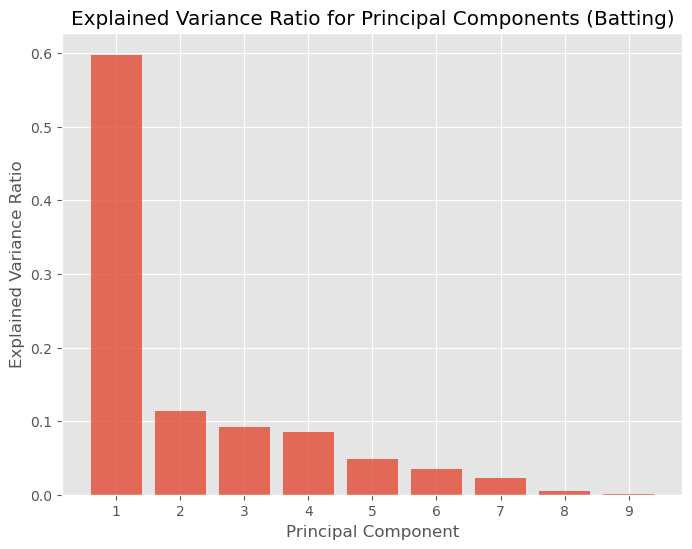

In [69]:
# Plot the explained variance ratio for each principal component
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance_ratio_batting) + 1), explained_variance_ratio_batting, alpha=0.8)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio for Principal Components (Batting)')
plt.xticks(range(1, len(explained_variance_ratio_batting) + 1))
plt.show()

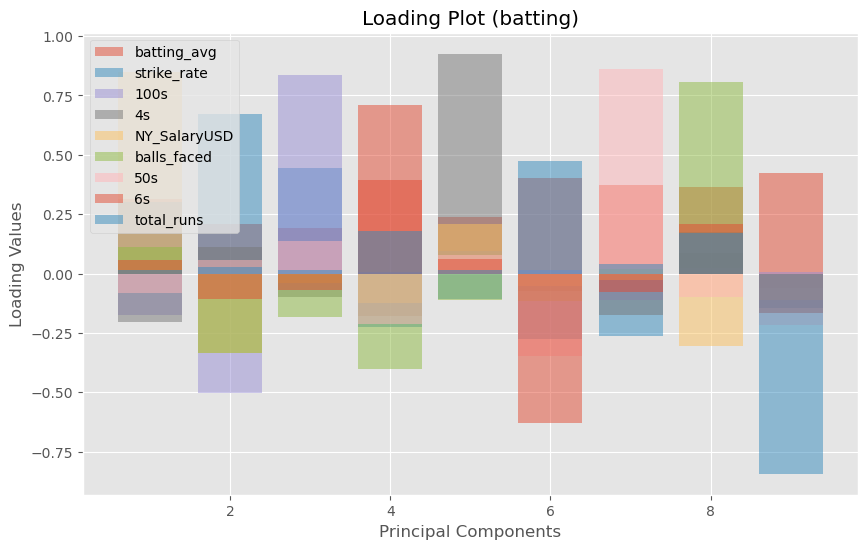

In [70]:
# Get the variable names
variable_names = list(stats_batting_df.columns)

# Plot the loading values for each variable on each PC
plt.figure(figsize=(10, 6))
for i in range(len(variable_names)):
    plt.bar(range(1, len(variable_names)+1), pca_batting.components_[i], alpha=0.5, label=variable_names[i])
plt.xlabel('Principal Components')
plt.ylabel('Loading Values')
plt.title('Loading Plot (batting)')
plt.legend()
plt.show()

## **Part 2: Bowlers**

### **(I) Loading and Cleaning the data**

In [18]:
bowling_file = filepath + 'bowling_merged.pkl'

# Load the .pkl file as a dataframe
bowling_df = pd.read_pickle(bowling_file)
bowling_df.head()

Player   Country    Role Season                         Team  \
0  A Ashish Reddy  Uncapped  Bowler   2015          Sunrisers Hyderabad   
1  A Ashish Reddy  Uncapped  Bowler   2016          Sunrisers Hyderabad   
2     A Choudhary  Uncapped  Bowler   2017  Royal Challengers Bangalore   
3        A Kumble     India  Bowler   2008  Royal Challengers Bangalore   
4        A Kumble     India  Bowler   2009  Royal Challengers Bangalore   

   SalaryUSD MatchCount  SeasonCount  balls_bowled  total_runs  total_wickets  \
0      33000          6            3          37.0        51.0            4.0   
1      33000          4            4          23.0        40.0            1.0   
2     299000          5            1         108.0       144.0            5.0   
3     500000         10            1         236.0       314.0            8.0   
4     500000         16            2         358.0       353.0           22.0   

   bowling_avg    economy  strike_rate  3whs  5whs   dots    4s    6s  
0    12.750000   8.270270     9.250000   0.0   0.0    9.0   1.0   3.0  
1    40.000000  10.434783    23.000000   0.0   0.0    5.0   4.0   2.0  
2    28.800000   8.000000    21.600000   0.0   0.0   42.0  13.0   6.0  
3    39.250000   7.983051    29.500000   1.0   0.0   85.0  27.0  14.0  
4    16.045455   5.916201    16.272727   1.0   1.0  138.0  18.0   8.0

In [19]:
# Turn the match count and phase into integers
bowling_df = bowling_df.dropna()

col_list = ['MatchCount', 'balls_bowled', 'total_wickets', '3whs', '5whs', 'dots','4s', '6s']
for col in col_list:
    bowling_df[col] = bowling_df[col].astype('int')

In [20]:
# Map the categories in 'Role' column to corresponding numeric values
role_list = list(bowling_df.Role.unique())
role_map = {role: 1 if role=='Allrounder' else 0 for role in role_list}
bowling_df.Role = bowling_df.Role.map(role_map)

In [21]:
# Let us now check for NaN values
bowl_columns_with_nan = bowling_df.columns[bowling_df.isna().any()].tolist()
print(bowl_columns_with_nan)

[]


In [22]:
bowling_df = bowling_df.reset_index(drop=True)

In [23]:
# Let us now keep track of when a player changed teams
bowling_df['changed_teams'] = 0
changed_teams_years = (bowling_df['Player'] == bowling_df['Player'].shift(1)) & (bowling_df['Team'] != bowling_df['Team'].shift(1))
bowling_df.loc[changed_teams_years, 'changed_teams'] = 1

In [24]:
# Let us also keep track of the next-year salary
bowling_df['NY_SalaryUSD'] = np.nan
player_change = (bowling_df['Player'] != bowling_df['Player'].shift(-1))
bowling_df.loc[~player_change, 'NY_SalaryUSD'] = bowling_df['SalaryUSD'].shift(-1)
bowling_df['NY_SalaryUSD'] = bowling_df['NY_SalaryUSD'].astype('float')

In [25]:
# inspect the final df
bowling_df.dropna(subset=['NY_SalaryUSD'], inplace=True)
bowling_df.head()

Player   Country  Role Season                         Team  \
0  A Ashish Reddy  Uncapped     0   2015          Sunrisers Hyderabad   
3        A Kumble     India     0   2008  Royal Challengers Bangalore   
4        A Kumble     India     0   2009  Royal Challengers Bangalore   
6        A Mishra     India     0   2011              Deccan Chargers   
7        A Mishra     India     0   2012              Deccan Chargers   

   SalaryUSD  MatchCount  SeasonCount  balls_bowled  total_runs  ...  \
0      33000           6            3            37        51.0  ...   
3     500000          10            1           236       314.0  ...   
4     500000          16            2           358       353.0  ...   
6     300000          14            4           324       369.0  ...   
7     300000          14            5           289       381.0  ...   

   bowling_avg   economy  strike_rate  3whs  5whs  dots  4s  6s  \
0    12.750000  8.270270     9.250000     0     0     9   1   3   
3    39.250000  7.983051    29.500000     1     0    85  27  14   
4    16.045455  5.916201    16.272727     1     1   138  18   8   
6    19.421053  6.833333    17.052632     1     0   130  26  14   
7    29.307692  7.910035    22.230769     1     0    89  18  19   

   changed_teams  NY_SalaryUSD  
0              0       33000.0  
3              0      500000.0  
4              0      500000.0  
6              0      300000.0  
7              0      300000.0  

[5 rows x 21 columns]

In [26]:
# inspect the shape of the df
bowling_df.shape

(626, 21)

In [27]:
# check for null values
null_counts = bowling_df.isnull().sum()
num_rows_with_null = len(null_counts[null_counts != 0])
num_rows_with_null

0

In [28]:
# inspect the data types present
bowling_df.dtypes

Player            object
Country           object
Role               int64
Season            object
Team              object
SalaryUSD          int64
MatchCount         int64
SeasonCount        int64
balls_bowled       int64
total_runs       float64
total_wickets      int64
bowling_avg      float64
economy          float64
strike_rate      float64
3whs               int64
5whs               int64
dots               int64
4s                 int64
6s                 int64
changed_teams      int64
NY_SalaryUSD     float64
dtype: object

In [29]:
# inspect the basic summary stats
bowling_df.describe()

Role     SalaryUSD  MatchCount  SeasonCount  balls_bowled  \
count  626.000000  6.260000e+02  626.000000   626.000000    626.000000   
mean     0.413738  5.342772e+05    9.551118     4.100639    186.156550   
std      0.492897  4.514641e+05    4.933618     2.568941    115.030658   
min      0.000000  1.500000e+04    1.000000     1.000000      6.000000   
25%      0.000000  1.600000e+05    5.000000     2.000000     82.250000   
50%      0.000000  4.500000e+05   10.000000     4.000000    184.500000   
75%      1.000000  8.000000e+05   14.000000     6.000000    284.750000   
max      1.000000  2.164000e+06   19.000000    12.000000    430.000000   

       total_runs  total_wickets  bowling_avg     economy  strike_rate  \
count  626.000000     626.000000   626.000000  626.000000   626.000000   
mean   240.151757       9.228435    33.752737    7.458202    24.471993   
std    141.050156       7.083991    23.284396    2.108864    14.673985   
min      3.000000       0.000000     3.000000    0.727273     6.000000   
25%    115.250000       3.000000    21.182353    6.892981    16.623188   
50%    244.500000       8.000000    27.000000    7.701397    20.447619   
75%    364.750000      14.000000    37.062500    8.632414    27.592857   
max    558.000000      34.000000   190.000000   14.000000   122.000000   

             3whs        5whs        dots          4s          6s  \
count  626.000000  626.000000  626.000000  626.000000  626.000000   
mean     0.789137    0.044728   66.420128   20.921725    8.317891   
std      1.073436    0.221802   45.666417   14.196516    5.513872   
min      0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000   25.250000    9.000000    4.000000   
50%      0.000000    0.000000   62.000000   19.000000    8.000000   
75%      1.000000    0.000000  102.000000   30.000000   12.000000   
max      6.000000    2.000000  211.000000   61.000000   29.000000   

       changed_teams  NY_SalaryUSD  
count     626.000000  6.260000e+02  
mean        0.226837  5.524545e+05  
std         0.419121  4.689205e+05  
min         0.000000  1.500000e+04  
25%         0.000000  1.580000e+05  
50%         0.000000  4.500000e+05  
75%         0.000000  8.500000e+05  
max         1.000000  2.214300e+06

### **(II) Initial Visualizations**

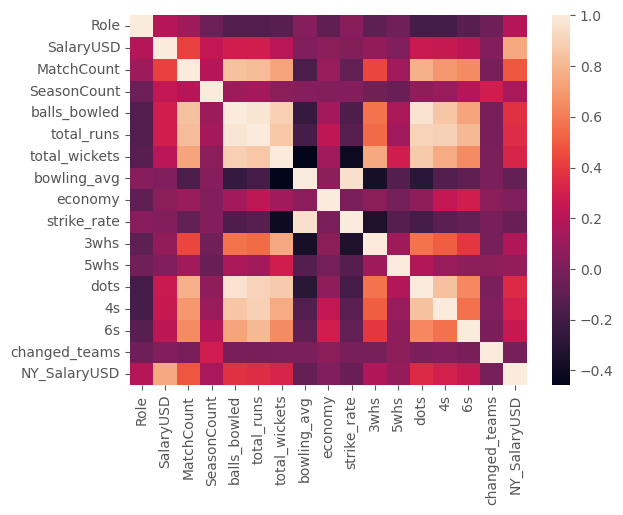

In [30]:
# find the correlations of the variables amongst each other
bowling_corr = bowling_df.corr()
sns.heatmap(bowling_corr)
plt.show()

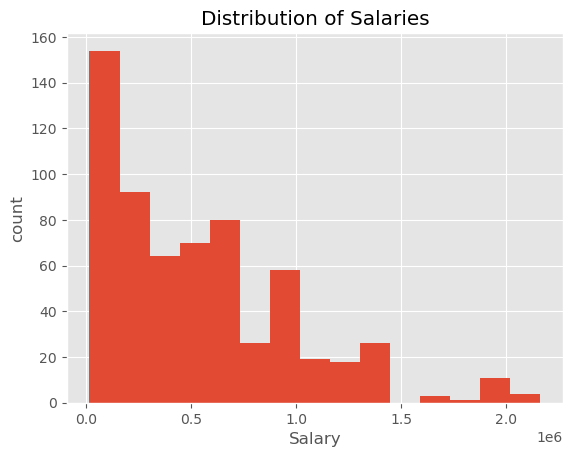

In [31]:
bowling_df.SalaryUSD.hist(bins='auto')
plt.xlabel('Salary')
plt.ylabel('count')
plt.title('Distribution of Salaries')
plt.show()

#### (a) General Player Statistics

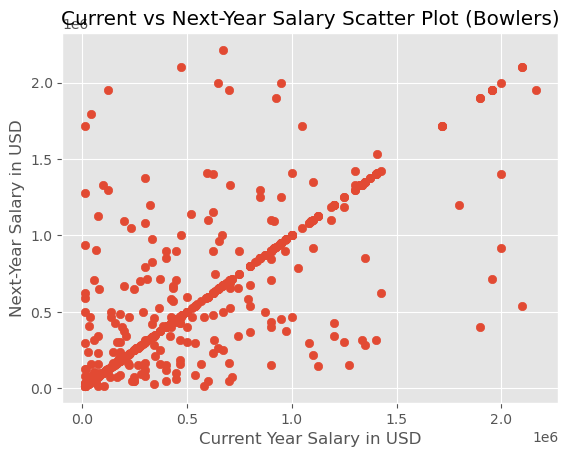

In [33]:
plt.scatter(bowling_df['SalaryUSD'], bowling_df['NY_SalaryUSD'])
plt.xlabel('Current Year Salary in USD')
plt.ylabel('Next-Year Salary in USD')
plt.title('Current vs Next-Year Salary Scatter Plot (Bowlers)')
plt.show()

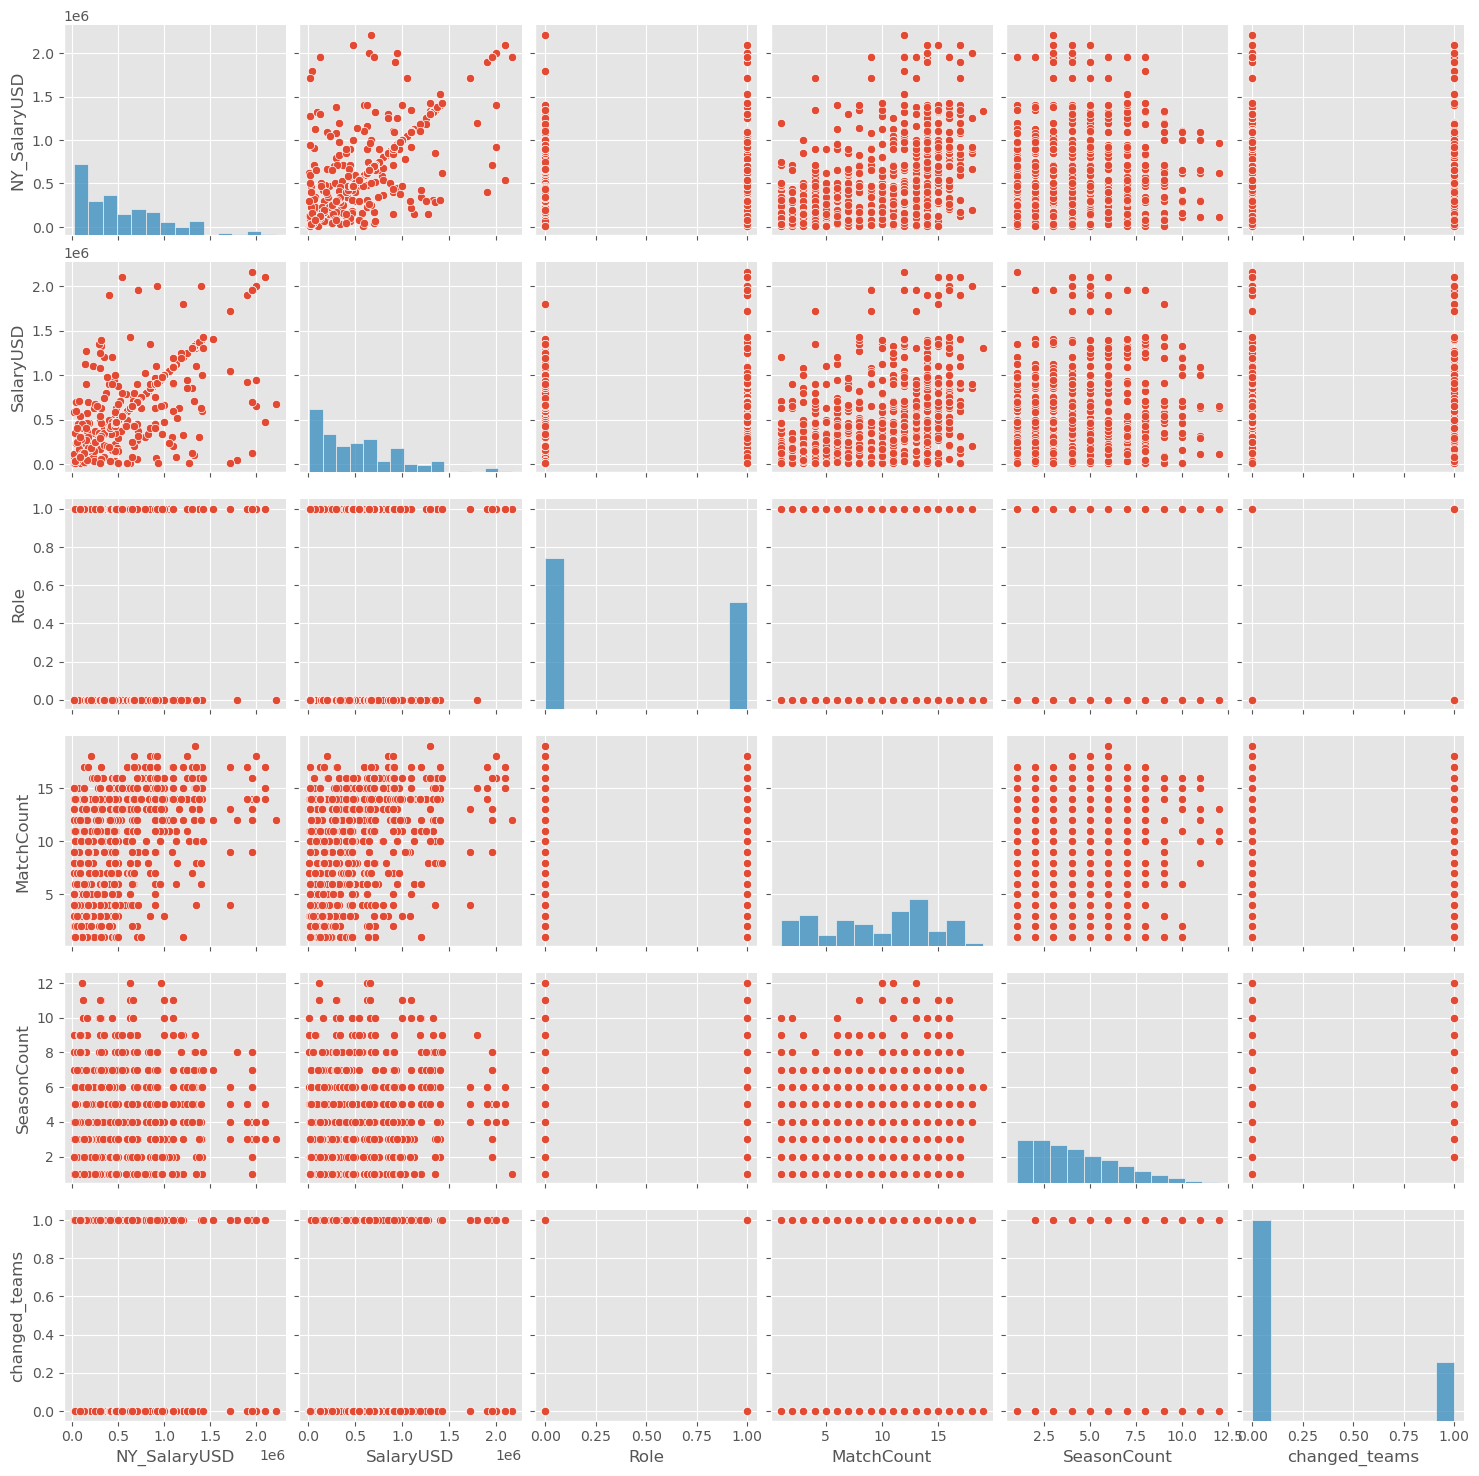

In [100]:
# Let us pairplot the NY_SalaryUSD with the other general player stats
gen_columns = ['NY_SalaryUSD', 'SalaryUSD', 'Role', 'Country', 'Team', 'MatchCount', 'SeasonCount', 'changed_teams']
gen_bowling_df = bowling_df[gen_columns].copy()
gen_bowling_df = gen_bowling_df.dropna()

sns.pairplot(gen_bowling_df)
plt.show()

In [101]:
gen_bowling_df.corr()

NY_SalaryUSD  SalaryUSD      Role  MatchCount  SeasonCount  \
NY_SalaryUSD       1.000000   0.751664  0.195752    0.483195     0.150920   
SalaryUSD          0.751664   1.000000  0.189527    0.420932     0.238130   
Role               0.195752   0.189527  1.000000    0.113340    -0.058208   
MatchCount         0.483195   0.420932  0.113340    1.000000     0.191795   
SeasonCount        0.150920   0.238130 -0.058208    0.191795     1.000000   
changed_teams     -0.017941   0.026155 -0.044540   -0.012581     0.284885   

               changed_teams  
NY_SalaryUSD       -0.017941  
SalaryUSD           0.026155  
Role               -0.044540  
MatchCount         -0.012581  
SeasonCount         0.284885  
changed_teams       1.000000

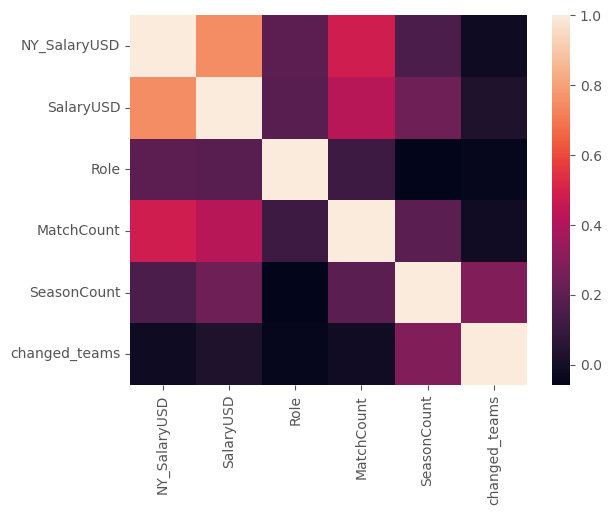

In [102]:
sns.heatmap(gen_bowling_df.corr())
plt.show()

#### (b) Player Performance Statistics

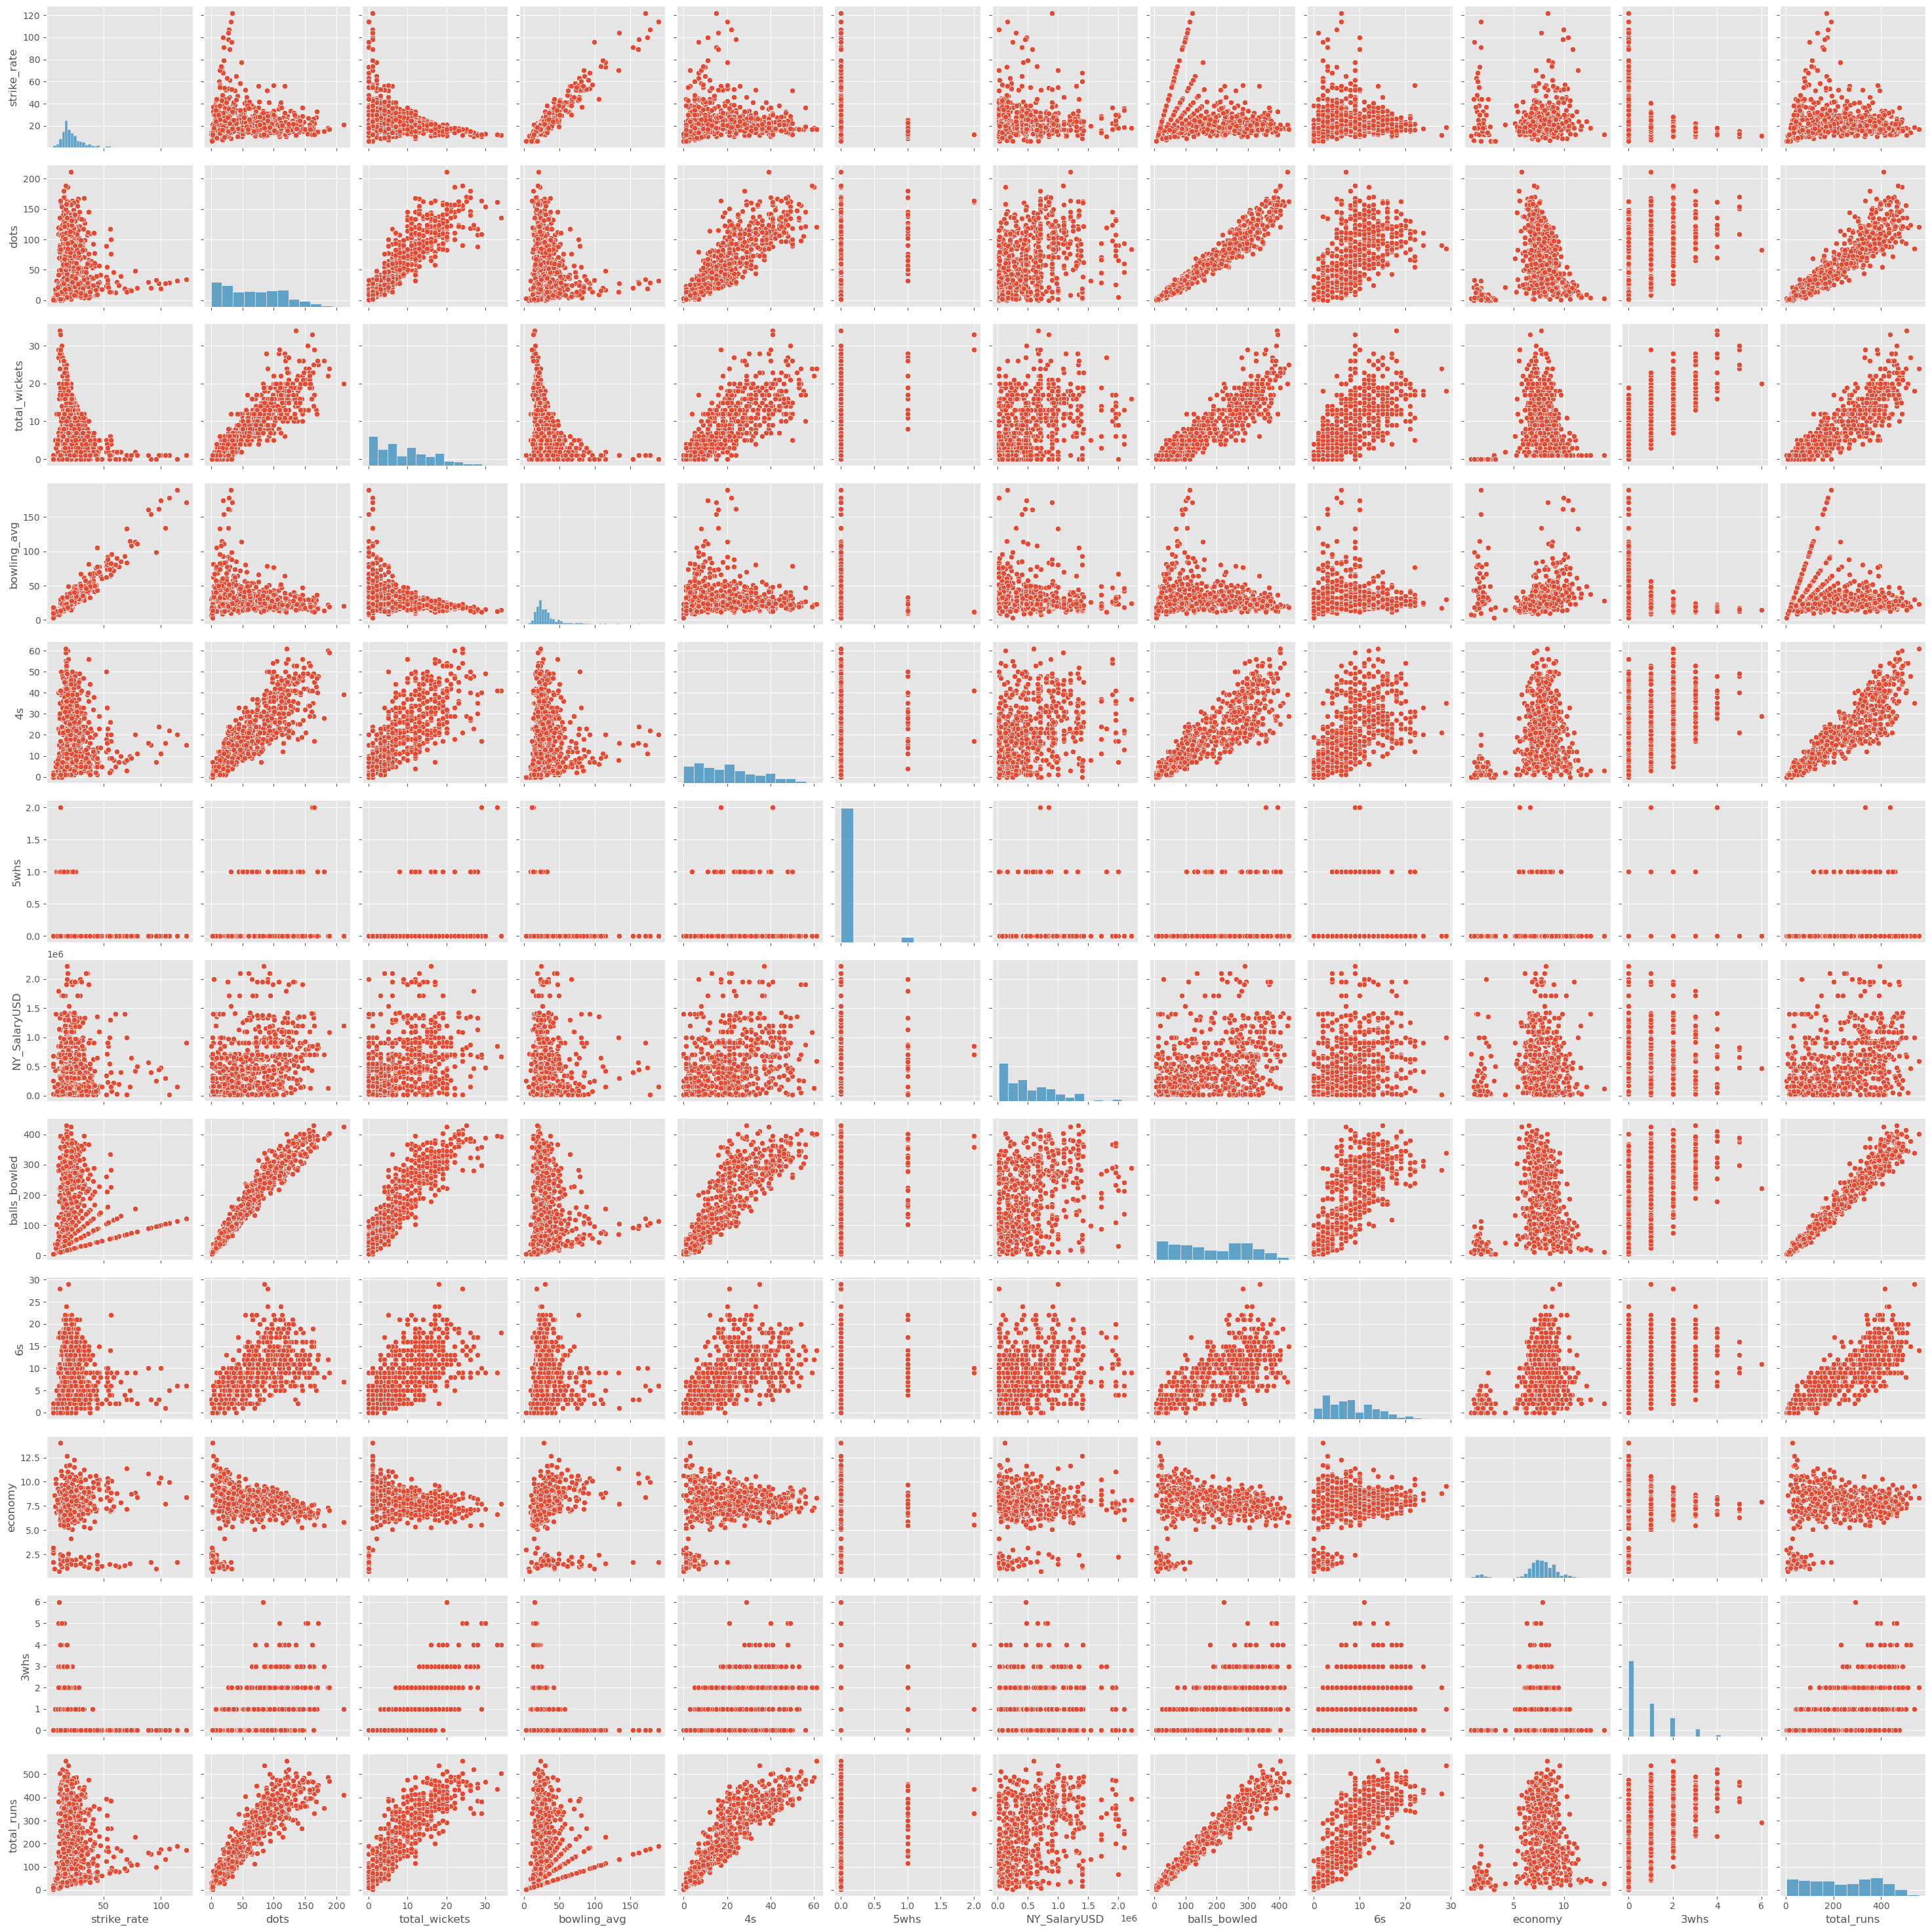

In [103]:
# Let's do the same thing for the statistics columns
stats_cols = list(set(bowling_df.columns) - set(gen_columns[1:]))
stats_cols = [col for col in stats_cols if col not in ['Player', 'Role', 'Season', 'SalaryUSD']]
stats_bowling_df = bowling_df[stats_cols]

sns.pairplot(stats_bowling_df)
plt.show()


In [104]:
stats_bowling_df.corr()

strike_rate      dots  total_wickets  bowling_avg        4s  \
strike_rate       1.000000 -0.193538      -0.406543     0.956685 -0.110761   
dots             -0.193538  1.000000       0.873915    -0.296818  0.840437   
total_wickets    -0.406543  0.873915       1.000000    -0.457628  0.755997   
bowling_avg       0.956685 -0.296818      -0.457628     1.000000 -0.146352   
4s               -0.110761  0.840437       0.755997    -0.146352  1.000000   
5whs             -0.130373  0.182485       0.288794    -0.134699  0.099690   
NY_SalaryUSD     -0.061331  0.342872       0.317454    -0.079176  0.302114   
balls_bowled     -0.158360  0.964167       0.890247    -0.249921  0.853411   
6s               -0.089589  0.638061       0.647760    -0.094548  0.564954   
economy          -0.004932  0.067671       0.128157     0.050816  0.237942   
3whs             -0.348498  0.571243       0.754140    -0.366549  0.509498   
total_runs       -0.126798  0.907055       0.859547    -0.185048  0.896370   

                   5whs  NY_SalaryUSD  balls_bowled        6s   economy  \
strike_rate   -0.130373     -0.061331     -0.158360 -0.089589 -0.004932   
dots           0.182485      0.342872      0.964167  0.638061  0.067671   
total_wickets  0.288794      0.317454      0.890247  0.647760  0.128157   
bowling_avg   -0.134699     -0.079176     -0.249921 -0.094548  0.050816   
4s             0.099690      0.302114      0.853411  0.564954  0.237942   
5whs           1.000000      0.088871      0.159324  0.064235 -0.020237   
NY_SalaryUSD   0.088871      1.000000      0.368479  0.258781  0.012715   
balls_bowled   0.159324      0.368479      1.000000  0.736493  0.133634   
6s             0.064235      0.258781      0.736493  1.000000  0.288983   
economy       -0.020237      0.012715      0.133634  0.288983  1.000000   
3whs           0.113598      0.175086      0.567377  0.387366  0.046722   
total_runs     0.124519      0.354478      0.974919  0.809413  0.227144   

                   3whs  total_runs  
strike_rate   -0.348498   -0.126798  
dots           0.571243    0.907055  
total_wickets  0.754140    0.859547  
bowling_avg   -0.366549   -0.185048  
4s             0.509498    0.896370  
5whs           0.113598    0.124519  
NY_SalaryUSD   0.175086    0.354478  
balls_bowled   0.567377    0.974919  
6s             0.387366    0.809413  
economy        0.046722    0.227144  
3whs           1.000000    0.544668  
total_runs     0.544668    1.000000

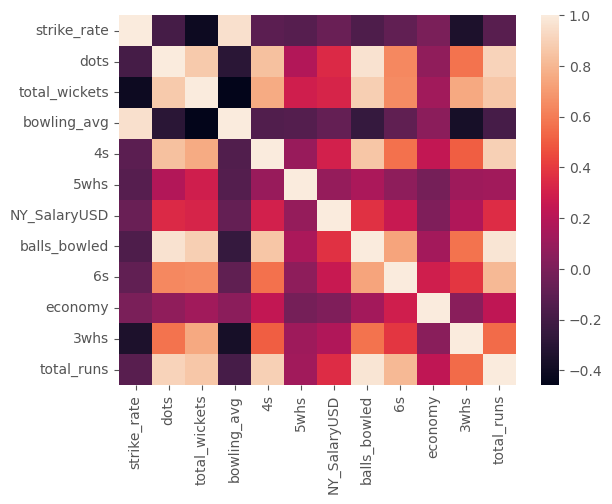

In [105]:
sns.heatmap(stats_bowling_df.corr())
plt.show()

### **(III) Statistical Significance**

#### (a) General Statistics

In [106]:
ny_salary = gen_bowling_df.NY_SalaryUSD
gen_cols_corr = [col for col in gen_columns if col not in ['NY_SalaryUSD', 'Country', 'Team']]

for col in gen_cols_corr:
    correlation_coef, p_value = stats.pearsonr(ny_salary, gen_bowling_df[col])
    if p_value < 0.05:
        print(f"Correlation coefficient {col}:", correlation_coef)
        print(f"P-value {col}:", p_value)

Correlation coefficient SalaryUSD: 0.7516638119369856
P-value SalaryUSD: 6.866530175368636e-115
Correlation coefficient Role: 0.19575154475942683
P-value Role: 7.984658348512253e-07
Correlation coefficient MatchCount: 0.4831948492728279
P-value MatchCount: 6.160499494029235e-38
Correlation coefficient SeasonCount: 0.1509203099230521
P-value SeasonCount: 0.00015052093437131227


#### (b) Player Performance Statistics

In [107]:
ny_salary = stats_bowling_df.NY_SalaryUSD
stats_cols_corr = list(stats_bowling_df.columns)[1:]

for col in stats_cols_corr:
    correlation_coef, p_value = stats.pearsonr(ny_salary, stats_bowling_df[col])
    if p_value < 0.05:
        print(f"Correlation coefficient {col}:", correlation_coef)
        print(f"P-value {col}:", p_value)

Correlation coefficient dots: 0.34287161852330217
P-value dots: 1.0413924303606802e-18
Correlation coefficient total_wickets: 0.31745423693268626
P-value total_wickets: 4.0096818619288215e-16
Correlation coefficient bowling_avg: -0.079176345681779
P-value bowling_avg: 0.047687611329948545
Correlation coefficient 4s: 0.302114477018675
P-value 4s: 1.1182959769459446e-14
Correlation coefficient 5whs: 0.08887100771452972
P-value 5whs: 0.026181503129249876
Correlation coefficient NY_SalaryUSD: 1.0
P-value NY_SalaryUSD: 0.0
Correlation coefficient balls_bowled: 0.36847901221138946
P-value balls_bowled: 1.4479109137487585e-21
Correlation coefficient 6s: 0.25878128181369164
P-value 6s: 4.895716641718444e-11
Correlation coefficient 3whs: 0.17508577148916005
P-value 3whs: 1.0531297942332621e-05
Correlation coefficient total_runs: 0.35447831484122605
P-value total_runs: 5.687822843842567e-20


### **(IV) PCA**

In [108]:
# Standardize the numerical columns
scaler_bowling = StandardScaler()
scaled_stats_bowling = scaler_bowling.fit_transform(stats_bowling_df)

In [109]:
# Perform PCA
pca_bowling = PCA()
principal_components_bowling = pca_bowling.fit_transform(scaled_stats_bowling)

In [110]:
# Explained variance ratio
explained_variance_ratio_bowling = pca_bowling.explained_variance_ratio_

# Print the explained variance ratio for each principal component
for i, ratio in enumerate(explained_variance_ratio_bowling):
    print(f"Explained variance ratio for PC{i+1} (bowling): {ratio:.4f}")

Explained variance ratio for PC1 (bowling): 0.4933
Explained variance ratio for PC2 (bowling): 0.1640
Explained variance ratio for PC3 (bowling): 0.0886
Explained variance ratio for PC4 (bowling): 0.0776
Explained variance ratio for PC5 (bowling): 0.0701
Explained variance ratio for PC6 (bowling): 0.0462
Explained variance ratio for PC7 (bowling): 0.0370
Explained variance ratio for PC8 (bowling): 0.0130
Explained variance ratio for PC9 (bowling): 0.0052
Explained variance ratio for PC10 (bowling): 0.0031
Explained variance ratio for PC11 (bowling): 0.0018
Explained variance ratio for PC12 (bowling): 0.0001


In [111]:
# Get the loadings of variables on principal components
loadings_bowling = pd.DataFrame(pca_bowling.components_.T, columns=[f'PC{i+1}' for i in range(principal_components_bowling.shape[1])])
loadings_bowling.index = stats_bowling_df.columns

# Sort variables by absolute loadings on PC1
sorted_loadings_pc1_bowling = loadings_bowling['PC1'].abs().sort_values(ascending=False)

# Top 5 variables with highest loadings on PC1
top_variables_pc1_bowling = sorted_loadings_pc1_bowling.head(5)
top_variables_pc1_bowling

balls_bowled     0.394546
total_runs       0.391899
total_wickets    0.391620
dots             0.384058
4s               0.354416
Name: PC1, dtype: float64

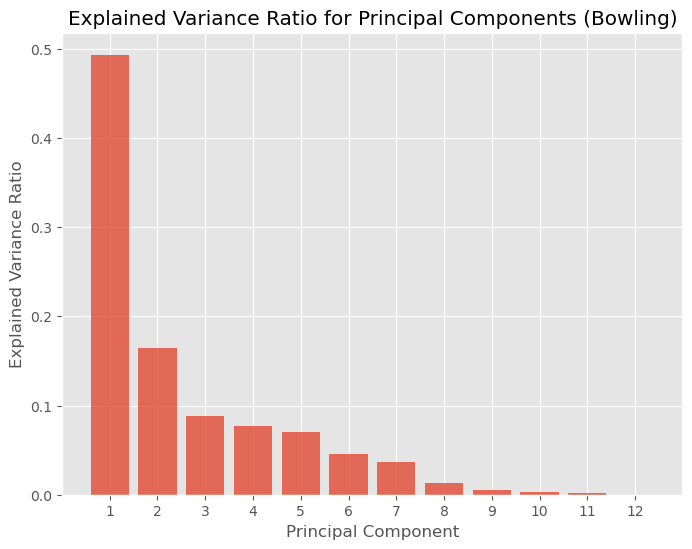

In [112]:
# Plot the explained variance ratio for each principal component
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance_ratio_bowling) + 1), explained_variance_ratio_bowling, alpha=0.8)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio for Principal Components (Bowling)')
plt.xticks(range(1, len(explained_variance_ratio_bowling) + 1))
plt.show()

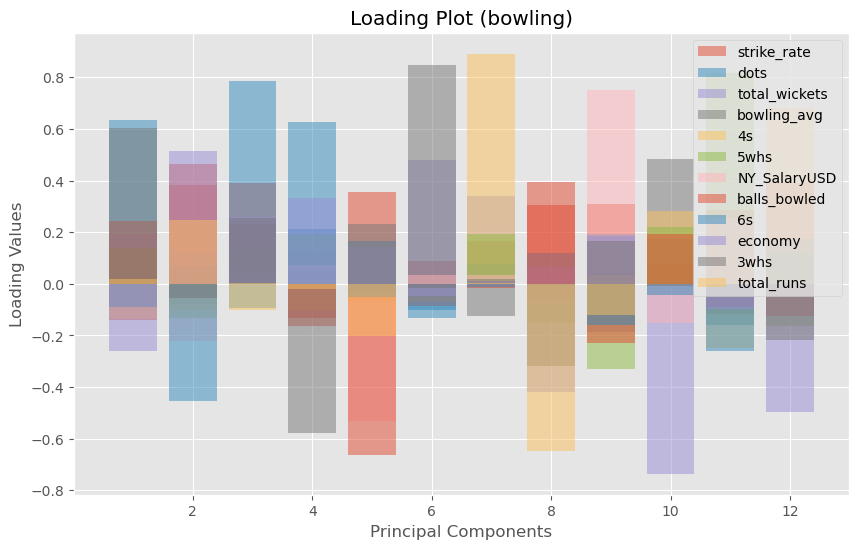

In [113]:
# Get the variable names
variable_names = list(stats_bowling_df.columns)

# Plot the loading values for each variable on each PC
plt.figure(figsize=(10, 6))
for i in range(len(variable_names)):
    plt.bar(range(1, len(variable_names)+1), pca_bowling.components_[i], alpha=0.5, label=variable_names[i])
plt.xlabel('Principal Components')
plt.ylabel('Loading Values')
plt.title('Loading Plot (bowling)')
plt.legend()
plt.show()

# **Part 3: Exporting the DFs**

In [116]:
output_dir = '../FinalDFs/PostEDA/'
os.makedirs(output_dir, exist_ok=True)

batting_df.to_pickle(output_dir + 'batting_df.pkl')
bowling_df.to_pickle(output_dir + 'bowling_df.pkl')